# Plot data for solvers

## Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import h5py as h5
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.sparse as sparse
import scipy.linalg as linalg
import itertools

from scipy import linalg as LA
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from scipy.sparse import coo_matrix

import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import json
import matplotlib.gridspec as gridspec


In [2]:
# # To run interactive plot.
# from matplotlib import interactive
# interactive(True)
# %matplotlib qt


In [3]:
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "text.usetex": False,
    "axes.formatter.use_mathtext": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.labelsize": 14
})



## Import data

In [4]:
dim = 2
has_all_data = True
data_filepaths = [
  ['../data/final/timed/solver_B_G_P_dim_2_exponential_{}.h5'.format(i) for i in range(9)],
  ['../data/final/timed/solver_B_G_dim_2_exponential_{}.h5'.format(i) for i in range(9)],
  ['../data/final/timed/solver_B_P_dim_2_exponential_{}.h5'.format(i) for i in range(9)],
  ['../data/final/timed/solver_B_dim_2_exponential_{}.h5'.format(i) for i in range(9)],
  ['../data/final/timed/solver_LU_dim_2_exponential_{}.h5'.format(i) for i in range(9)],
  ['../data/final/timed/solver_PU_dim_2_exponential_{}.h5'.format(i) for i in range(9)]
]

solver_names = ['BiCGSTAB, ILUT, "solveWithGuess()"',
                'BiCGSTAB, "solveWithGuess()"',
                'BiCGSTAB, ILUT, "solve()"',
                'BiCGSTAB, "solve()"',
                'SparseLU',
                'PardisoLU',
                # 'SparseQR',
                ]

### Implicit error vs. number of iterations

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_error_implicit = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            N_iterations = data.attrs['refinement_iterations']
            iterations = np.linspace(0, N_iterations, N_iterations, endpoint=False, dtype=int)
            error_implicit = [data.attrs['err_norm_inf_analytic_{:05d}'.format(i)] for i in iterations]

            all_iterations.append(iterations)
            all_error_implicit.append(error_implicit)
    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    error_implicit = np.mean(all_error_implicit, axis=0)    
    # Plot implicit error norm. 
    ax.semilogy(iterations, error_implicit, '-', label=solver_names[solver_id])
        
ax.grid(True, which="both")
ax.set_ylabel('$e_\infty$')
ax.set_xlabel('iteration')
fig.legend(loc='upper left', bbox_to_anchor=(0.6, 1),ncol=2)
fig.tight_layout()
if 0:
    plt.savefig('../manuscript/figures/solvers_convergence.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()


## solver iterations

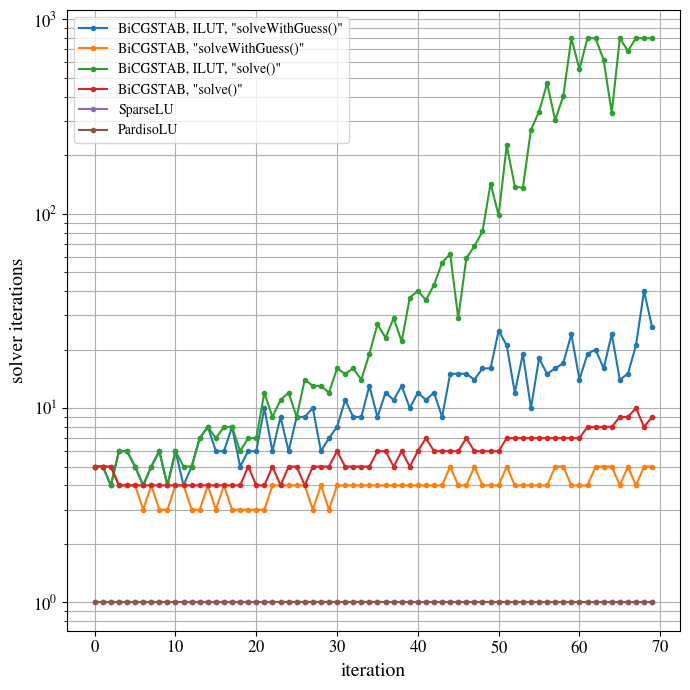

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_solver_iterations = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            N_iterations = data.attrs['refinement_iterations']
            iterations = np.linspace(0, N_iterations, N_iterations,
                                endpoint=False, dtype=int)
            solver_iterations = [
                data.attrs['N_solver_iters_{:05d}'.format(i)] for i in iterations]

            all_iterations.append(iterations)
            all_solver_iterations.append(solver_iterations)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    solver_iterations = np.mean(all_solver_iterations, axis=0)    
    # Plot.
    ax.semilogy(iterations, solver_iterations, '.-', label=solver_names[solver_id])

ax.grid(True, which="both")
ax.set_ylabel('solver iterations')
ax.set_xlabel('iteration')
ax.legend()
fig.tight_layout()
if 0:
    plt.savefig('../results/solvers_iterations.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()

## Solve times


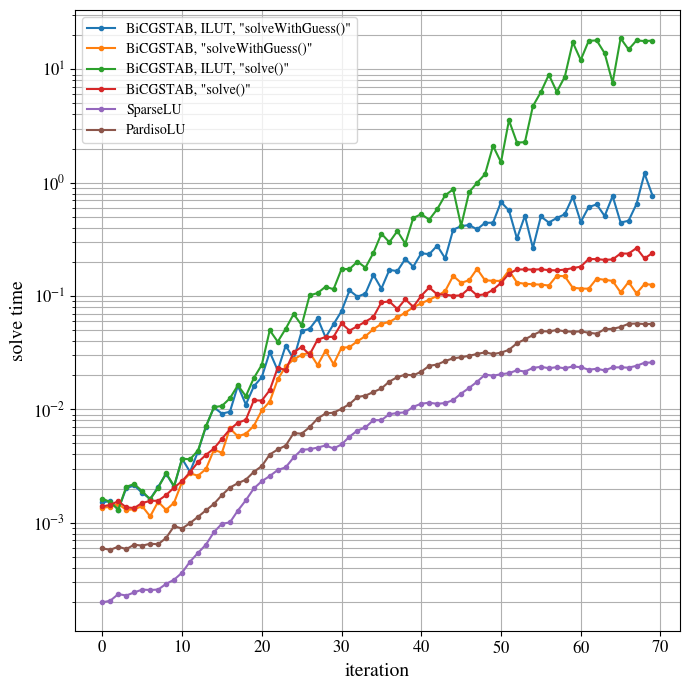

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_times = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            N_iterations = data.attrs['refinement_iterations']
            iterations = np.linspace(0, N_iterations, N_iterations,
                                endpoint=False, dtype=int)
            times = [data['timer'].attrs['solver_start_{:05d}-solver_stop_{:05d}'.format(i, i)] for i in iterations]

            all_iterations.append(iterations)
            all_times.append(times)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    times = np.mean(all_times, axis=0)    
    # Plot.
    ax.semilogy(iterations, times, '.-', label=solver_names[solver_id])

ax.grid(True, which="both")
ax.set_ylabel('solve time')
ax.set_xlabel('iteration')
ax.legend()
fig.tight_layout()
if 0:
    plt.savefig('../results/solvers_times.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()

# convergence + solver

In [27]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 

In [5]:
fig = plt.figure(figsize=(8, 5), tight_layout=True)
gs = gridspec.GridSpec(2, 2, width_ratios=[0.65, 1], height_ratios=[1, 0.3])

# Convergence
ax = fig.add_subplot(gs[0, 0])
for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_error_implicit = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            N_iterations = data.attrs['refinement_iterations']
            iterations = np.linspace(0, N_iterations, N_iterations, endpoint=False, dtype=int)
            error_implicit = [data.attrs['err_norm_inf_analytic_{:05d}'.format(i)] for i in iterations]

            all_iterations.append(iterations)
            all_error_implicit.append(error_implicit)
    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    error_implicit = np.mean(all_error_implicit, axis=0)    
    # Plot implicit error norm. 
    ax.semilogy(iterations, error_implicit, '-', label=solver_names[solver_id], lw=1)
        
ax.grid(True, which="both")
ax.set_ylabel('$e_\infty$')
ax.set_xlabel('iteration')

# Solvers.
ax = fig.add_subplot(gs[0, 1], projection='3d')

for solver_id, solver_data_filepath in enumerate(data_filepaths):
    all_iterations = []
    all_solver_iterations = []
    all_times = []
    for data_filepath in solver_data_filepath:
        with h5.File(data_filepath, "r") as data:
            N_iterations = data.attrs['refinement_iterations']
            iterations = np.linspace(0, N_iterations, N_iterations,
                                endpoint=False, dtype=int)
            solver_iterations = [
                data.attrs['N_solver_iters_{:05d}'.format(i)] for i in iterations]
            times = [data['timer'].attrs['solver_start_{:05d}-solver_stop_{:05d}'.format(i, i)] for i in iterations]

            all_iterations.append(iterations)
            all_solver_iterations.append(solver_iterations)
            all_times.append(times)

    # Compute average.
    iterations = np.mean(all_iterations, axis=0)    
    solver_iterations = np.mean(all_solver_iterations, axis=0)    
    times = np.mean(all_times, axis=0)    
    # Plot.
    ax.plot(iterations, np.log10(solver_iterations), np.log10(times), '-', label=solver_names[solver_id])


ax.set_xlabel(r'iteration')
ax.set_yticklabels([f"$10^{int(n)}$" for n in ax.get_yticks()])
ax.set_zticklabels([r"$10^{" + str(int(n)) + "}$" for n in ax.get_zticks()])
# ax.set_ylabel(r'$\log_{10} ($' + 'solver iterations' + '$)$')
# ax.set_zlabel(r'$\log_{10} ($' + 'solve time' + '$)$')
ax.set_ylabel(r'solver iterations')
ax.set_zlabel(r'solve time')
# ax.set_zscale('log')
# ax.legend(loc='upper left', bbox_to_anchor=(0.6, 1))
ax.view_init(20, -144)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# legend
handles,labels=ax.get_legend_handles_labels()
ax = fig.add_subplot(gs[1,:])
ax.legend(handles=handles, labels=labels, ncol=2, loc='upper left',bbox_to_anchor=(0.1, 0.9))
ax.axis('off')

if 0:
    plt.savefig('../manuscript/figures/solvers.png', dpi=300,
                transparent=False, bbox_inches='tight')
plt.show()

/tmp/ipykernel_112889/939283934.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"$10^{int(n)}$" for n in ax.get_yticks()])
/tmp/ipykernel_112889/939283934.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels([r"$10^{" + str(int(n)) + "}$" for n in ax.get_zticks()])


/home/mjancic/.local/lib/python3.10/site-packages/ipykernel/eventloops.py:107: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  app.exec_()


# Spectrum and matrix

In [64]:
print('WARNING: can take up to 30 minutes due to large matrices.')
data_filepath = '../data/final/solver_B_G_P_dim_2_exponential_0.h5'
output_file_postfix = '_eigenvalues'
out_file = '../data/final/' + data_filepath.split('/')[-1].split('.h5')[0] + output_file_postfix + '.json'
iterations = [3, 25, 50]

eigen_data = {}
# compute new eigenvectors.

if 1:
    with h5.File(data_filepath, "r") as dataFile:
        for iteration in iterations:
            print(iteration)
            i, j, val = dataFile["Matrix_{:05d}".format(iteration)][()]
            i = (i-1).astype(int)
            j = (j-1).astype(int)
            mat = sparse.coo_matrix((val, (i, j)))
            # better eigenvalue algorithms available for dense matrices
            dense = mat.toarray()
            eVal, eVec = linalg.eig(dense)
            serializable_eVal = [[e.real, e.imag] for e in eVal]
            eigen_data['{}'.format(iteration)] = serializable_eVal
        
        # Save eigenvalues to file.
        with open(out_file, "w") as write_file:
            json.dump(eigen_data, write_file, indent=2)
else:
    #import
    with open(out_file) as dataFile:
        eigen_data = json.load(dataFile)
    


3
25
50


In [83]:
with h5.File(data_filepath, "r") as dataFile:
    fig, ax = plt.subplots(2, 3, figsize=(9, 7))
    for col_idx, iteration in enumerate(iterations):
        eVal = [complex(val[0] + 1j * val[1]) for val in eigen_data['{}'.format(iteration)]]

        ax[1][col_idx].plot(np.real(eVal), np.imag(eVal), 'ko', markerfacecolor="none", ms=3)
        ax[1][col_idx].set_xlabel('$\Re (\lambda)$')
        eVal_real = [e.real for e in eVal]
        eVal_real_max = max(eVal_real)
        eVal_max = eVal[eVal_real.index(eVal_real_max)]
        s = '$\lambda _\max = %.1f + \mathrm{i}%.1f$' % (eVal_max.real, eVal_max.imag)
        ax[1][col_idx].text(0.04, 0.95, s, bbox=dict(facecolor='white', alpha=0), transform=ax[1][col_idx].transAxes)
        ax[1][col_idx].locator_params(axis='x', nbins=4)


        M = dataFile["Matrix_{:05d}".format(iteration)][:] # array of triplets!
        dataType = dataFile['domain_{:05d}/types'.format(iteration)][:] # Node type (boundary or interior)
        # convert triplets to matrix
        N = len(dataType)
        row = M[0,:] - 1
        col = M[1,:] - 1
        val = M[2,:]
        matrix = coo_matrix((val, (row, col)), shape = (N, N)).toarray()
        M = matrix
        ax[0][col_idx].spy(M, ms = 1, marker = '.', c = 'black')
        ticks = np.arange(0, M.shape[0] + 1, int(M.shape[0] / 4), dtype = 'int')
        ax[0][col_idx].axes.set_xticks(ticks)
        ax[0][col_idx].axes.set_yticks(ticks)
        ax[0][col_idx].set_aspect('equal')
        ax[0][col_idx].set_title('iteration = {}'.format(iteration))


ax[1][0].set_ylabel('$\Im (\lambda)$')

fig.tight_layout()
if 0:
    plt.savefig('../results/spectra.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()